In [1]:
#!pip install scikit-image

In [54]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras import datasets, layers, models, regularizers, initializers
from skimage.io import imshow
from skimage.transform import rotate
from skimage.filters.edges import convolve

from skimage.io import imshow, imread
from skimage.transform import resize
from skimage.color import rgb2gray

np.random.seed(42)

In [3]:
def random_crop(img, margin=0.2):
    #randomly chop off margin amounts; for augumenting data
    
    w,h,nchannels = img.shape
    lmargin, rmargin = np.random.randint( 0, w*margin, size=2 )
    bmargin, tmargin = np.random.randint( 0, h*margin, size=2 )
    
    ret = img[bmargin:-tmargin-1, lmargin:-rmargin-1,:]
    
    return ret

def augment( images, labels, factor=5 ):
    for j, (image, label) in enumerate( zip(images, labels) ):
        print( "{}/{} images".format(j, len(images)) )
        for i in range(factor):
            aug = rotate( image, np.random.randint(-10,10) )
            aug = random_crop(aug)
            
            if np.random.binomial(1,0.5): #half the time randomly
                aug = aug[:,::-1] #flip left-right
                
            yield aug, label

# Automatic filter-finding: an introduction to convolutional neural networks

What if, instead of trying a bunch of filters, we could just use an automatic parameter-fitting process to find a filter for us?

We can! One common technique is to use convolutional filters to find features, and use gradient descent to find convolutional kernals that result in features which act as reliable discriminators.

Let's do it! We'll use TensorFlow's `Keras` API to define a pipeline which takes, on one end, a stack of images, performs several operatons on it, and returns a list of predictions; one for each image. 

TensorFlow is able to automatically find the gradient of the all parameters of every operation in the pipeline, and can therefore use gradient-descent to find parameters which result in good predictions on the training set.

In [4]:
import sys
sys.path.append("src")

In [5]:
from pipeline import get_images

Get some cat/dog training data.

In [6]:
cat_images = [x for _,x in get_images("data/cat_dog/cat")]
dog_images = [x for _,x in get_images("data/cat_dog/dog")]

Put together a stack of training and test images, and corresponding label vectors.

In [7]:
# stack all images
images = cat_images+dog_images
y = np.array([1]*len(cat_images) + [0]*len(dog_images))

In [8]:
#shuffle images and target var
i = np.random.choice( np.arange(len(images)), size=len(images), replace=False)
images = [images[ix] for ix in i]
y = y[i]

In [9]:
# do train test split
n_train = int(len(images)*0.80)

images_train = images[:n_train]
labels_train = y[:n_train]

images_test = images[n_train:]
labels_test = y[n_train:]

`images_train` and `images_test` aren't numpy vectors - they're Python lists of inconsistently-sized images matrices. We want to convert each to a numpy matrix holding a stack of images.

To do this, we'll perform two steps for every object:
1. "Data augmentation" - modify each image by cropping, rotating, and flipping to produce a several sligthly different images. I'm doing this here because the dataset is very small, and convolutional neural network usually need a few thousand images to get good results.
2. "Featurization" - converting each image into a consistently-sized matrix, and then stacking them together.

In [12]:
featurize = lambda x: resize(rgb2gray(x), (100,100))

In [13]:
aug_pairs = list( [(featurize(x),y) for x,y in \
                    augment( images_train, labels_train, factor=4 )] )

0/320 images
1/320 images
2/320 images
3/320 images
4/320 images
5/320 images
6/320 images
7/320 images
8/320 images
9/320 images
10/320 images
11/320 images
12/320 images
13/320 images
14/320 images
15/320 images
16/320 images
17/320 images
18/320 images
19/320 images
20/320 images
21/320 images
22/320 images
23/320 images
24/320 images
25/320 images
26/320 images
27/320 images
28/320 images
29/320 images
30/320 images
31/320 images
32/320 images
33/320 images
34/320 images
35/320 images
36/320 images
37/320 images
38/320 images
39/320 images
40/320 images
41/320 images
42/320 images
43/320 images
44/320 images
45/320 images
46/320 images
47/320 images
48/320 images
49/320 images
50/320 images
51/320 images
52/320 images
53/320 images
54/320 images
55/320 images
56/320 images
57/320 images
58/320 images
59/320 images
60/320 images
61/320 images
62/320 images
63/320 images
64/320 images
65/320 images
66/320 images
67/320 images
68/320 images
69/320 images
70/320 images
71/320 images
72

In [14]:
# build X and y from augmented images
X_train = np.stack( [x for x,y in aug_pairs] )
y_train = np.stack( [y for x,y in aug_pairs] )

In [15]:
# featurize test images
X_test = np.stack( [featurize(x) for x in images_test] )
y_test = labels_test

In [21]:
# tensorflow needs each image sample to be 1-channel, not 0-channel
X_train = np.expand_dims( X_train, axis=3 )
X_test = np.expand_dims( X_test, axis=3 )

The next step is to define a model using the standard `Keras` format. The most simple Keras model is a `Sequential` model, which takes several "layers" that have input and output tensors (i.e, multidimensional arrays) of consistent size.

The following sequential model is one of the simplest possible models, with a single convolution filter, followed by a flattening of the output and the application of a fully connected sigmoid layer.

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(1, (5, 5), activation='linear', 
                        input_shape=(100, 100, 1),
                        kernel_regularizer=regularizers.l2(0.003)))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 1)         26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [24]:
1-y_test.mean()

0.5375

In [25]:
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.003)))

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 1280 samples, validate on 80 samples
Epoch 1/100
1280/1280 [==============================] - 4s 3ms/sample - loss: 0.7309 - accuracy: 0.4859 - val_loss: 0.7006 - val_accuracy: 0.5000
Epoch 2/100
1280/1280 [==============================] - 3s 2ms/sample - loss: 0.6940 - accuracy: 0.5664 - val_loss: 0.7054 - val_accuracy: 0.4625
Epoch 3/100
1280/1280 [==============================] - 3s 2ms/sample - loss: 0.6839 - accuracy: 0.5953 - val_loss: 0.7105 - val_accuracy: 0.4625
Epoch 4/100
1280/1280 [==============================] - 3s 2ms/sample - loss: 0.6677 - accuracy: 0.6531 - val_loss: 0.7253 - val_accuracy: 0.4625
Epoch 5/100
1280/1280 [==============================] - 3s 3ms/sample - loss: 0.6523 - accuracy: 0.6828 - val_loss: 0.7264 - val_accuracy: 0.4125
Epoch 6/100
1280/1280 [==============================] - 3s 3ms/sample - loss: 0.6349 - accuracy: 0.7297 - val_loss: 0.7304 - val_accuracy: 0.5250
Epoch 7/100
1280/1280 [==============================] - 4s 3ms/sample -

KeyboardInterrupt: 

Let's grab a single image and see the input and output of each layer...

In [34]:
i = 5
last_img = X_test[i:i+1]

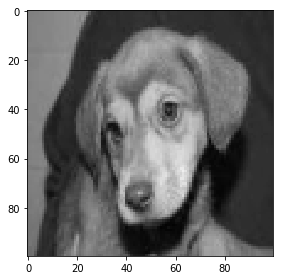

In [35]:
imshow( last_img[0,:,:,0] )

`model.layers` contains all the layers..

In [36]:
model.layers

Each layers is simply a function - we can feed the image into the first layer, to get that layer's output...

In [59]:
# pipe the image into the first layer
layer0_output = model.layers[0]( last_img.astype(np.float32) ).numpy()

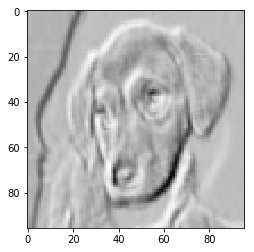

In [60]:
plt.imshow( layer0_output[0,:,:,0], cmap="Greys" )

The first layer is a convolution filter...

In [61]:
W, b = model.layers[0].get_weights()

In [62]:
kernal = W[:,:,0,0]

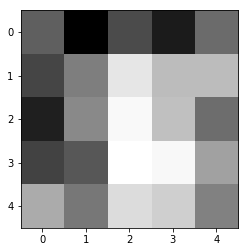

In [63]:
plt.imshow( kernal, cmap="Greys" )

We can just apply this convolutional kernal by hand using sklearn's `convolve` function.

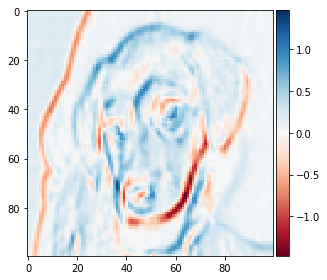

In [64]:
imshow( convolve(last_img[0,:,:,0], kernal) )

At this point, we've "featurized" the image using the convolutional filter. The next step is to flatten it, and then use a supervised learning technique.

In [65]:
layer1_output = model.layers[1]( layer0_output ).numpy()
layer1_output.shape

(1, 9216)

Row vector, 9604 wide

The standard approach is to use a logistic regression layer, in the parlance of neural networks called a "sigmoid layer".

In [83]:
W, b = model.layers[2].get_weights()

In [84]:
_, n_flat = W.T.shape #1 rows, one for each fully connected neuron
          #each row has 9604 connections, to each of the pixels in the previous layer
          #but all flattened out
n_flat

9216

In the context of image analysis, logistic regression is very similar to applying a mask filter to an image, and then tallying up all the pixels that pass through the mask filter.

Here's the "mask filter" that we found using gradient descent:

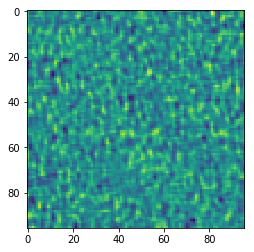

In [85]:
width = int(n_flat**0.5)
plt.imshow( W.T.reshape(width,width) )

The procedure is to take the pairwise product of this mask-filter against an image, take the sum, and then apply the sigmoid function.

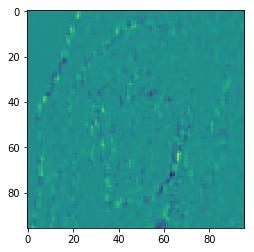

In [86]:
plt.imshow( (W.flatten() * layer1_output.flatten()).reshape(width,width), 
            vmin=-0.2, vmax=0.2 )

In [87]:
(W.T) @ layer1_output.flatten()

array([0.5291865], dtype=float32)

In [88]:
(W.flatten() * layer1_output.flatten()).sum() + b

array([0.66887254], dtype=float32)

In [89]:
layer2_output = (W.T) @ layer1_output.flatten() + b

In [90]:
layer2_output

array([0.668874], dtype=float32)

In [91]:
tf.keras.activations.sigmoid( layer2_output ).numpy()

array([0.661251], dtype=float32)

Let's see how the model performs on the training set:

In [99]:
((model.predict( X_train ).flatten() > 0.5) == y_train).mean()

0.9953125

Nearly perfect.

How about the testing set?

In [100]:
((model.predict( X_test ).flatten() > 0.5) == y_test).mean()

0.525

In [102]:
1-y_test.mean()

0.5375

Absolutely useless. Predicing the majority class would give better accuracy than this model.

**Question** Why is this? (Hint: look at the "mask filter").